# GAN Example in Pytorch
## STAT 940

### Introduction

In this tutorial we will train a simple Variational Autoencoder in following five steps:
- Step 1)  Import libraries and set parameters
- Step 2) Load and prepare data
- Step 3) Model Definition
- Step 4) Set up optimizers and loss functions
- Step 5) Learning model and fit it on training data

Also we will see how to:
- Save and load learned models
- Generate images

### STEP 1 - Import libraries and set parameters

First, we will import the necessary libraries and packages that are needed for VAE.
- 1) Numpy: NumPy is the fundamental package for scientific computing with Python
- 2) torch, torch.nn, torch.nn.functional, torch.optim: Pytorch imports for building custom neural networks containing
    - Sequential model type: This provides linear stack of neural network layers and it is useful in MLP and CNN nets.
    - Core layers (Linear, Dropout, ReLU): these layers are used in most neural networks
    - Convolutional, ConvTranspose
    - data tools: DataSet for custom data sets, DataLoader for loading in data
    - optim: optimizers
- 3) torchvision: Vision specific Pytorch. Provides useful augmentations, datasets, pretrained models
- 4) matplotlib.pyplot: for plotting figures and images

In [1]:
# 1)
import numpy as np
# 2)
import torch     
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
# 3)
import torchvision
# 4)
import matplotlib.pyplot as plt

In [2]:
np.random.seed(940) # set seed for reproducibility (within numpy)
torch.manual_seed(940) # set seed for reproducibility (within pytorch)

#### Parameters

In [3]:
batch_size = 16      #batch size
epochs = 100        #epoch size

#### Set-up GPU (optional)

Leverage GPUs for faster training of neural networks. This section will help you set up GPUs on Pytorch

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # check is GPU is available
print(device)

cuda:0


### STEP 2 - Load and prepare data

In [5]:
train = torchvision.datasets.MNIST("./", train=True, download=True)
test = torchvision.datasets.MNIST("./", train=False, download=True)

print('# train:', len(train))
print("# test:", len(test))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

# train: 60000
# test: 10000


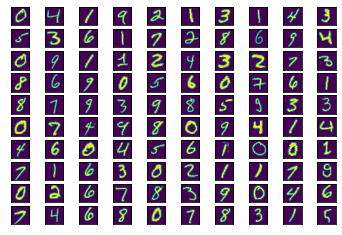

In [6]:
# show some images
plt.figure()                                      # create new figure
fig_size = [20, 20]                               # specify figure size
plt.rcParams["figure.figsize"] = fig_size         # set figure size

#Plot firs 100 train image of dataset
for i in range(1,101):                          
    ax = plt.subplot(10, 10, i)                   # Specify the i'th subplot of a 10*10 grid
    img = train[i][0]                             # train[i][0] is the image, train[i][1] is the label
    ax.get_xaxis().set_visible(False)             # Disable plot axis.
    ax.get_yaxis().set_visible(False)
    plt.imshow(img)
    
plt.show()

#### Prepare Data

In [7]:
# transforms
# first convert image to tensor with values in [0, 1]
# normalize image over all channels to be between [-1, 1]

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=0.5, std=0.5)
])

# attach transforms to dataset
train = torchvision.datasets.MNIST("./", train=True, transform=transform, download=True)
test = torchvision.datasets.MNIST("./", train=False, transform=transform, download=True)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True) # shuffle training examples
test_loader = DataLoader(test, batch_size=1, shuffle=False) # don't shuffle test set

### STEP 3 - Model Definition
Here, we will define a very simple GAN. It consists of a generator and discriminator. In order to keep the performance of both generator and discriminator similar, we try to use a similar architecture (4 layer FFN).

We use a hidden embedding size of 100.

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(100, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, 28 * 28)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 1)
    
    # forward method
    def forward(self, x):
        x = x.view((-1, 28 * 28))
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.flatten(torch.sigmoid(self.fc4(x)))

In [9]:
generator = Generator()
discriminator = Discriminator()

# test out on one batch of images - each batch is given as a list of [Images, Labels]
batch = next(iter(train_loader))
images = batch[0]
labels = batch[1]

print("Batch shape (image): ", images.shape)
print("Batch shape (label): ", labels.shape)

# feed batch to model
output = discriminator(images)
print("Output shape:", output.shape)

# test generator
zeros = torch.zeros((images.shape[0], 100))
ones = torch.ones((images.shape[0], 100))
z = torch.normal(zeros, ones)
output = generator(z)
print("Output shape:", output.shape)

Batch shape (image):  torch.Size([16, 1, 28, 28])
Batch shape (label):  torch.Size([16])
Output shape: torch.Size([16])
Output shape: torch.Size([16, 784])


In [10]:
# model summary (without logging)
generator = Generator()
discriminator = Discriminator()

generator.to(device) # move model to GPU
discriminator.to(device)
print(generator)
print(discriminator)

criterion = nn.BCELoss()

Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
)
Discriminator(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
)


### STEP 4 - Set up optimizers and loss functions

In [11]:
opt_gen = optim.Adam(generator.parameters(), lr=0.0002)
opt_dis = optim.Adam(discriminator.parameters(), lr=0.0002)

#### Training Loop

In [12]:
def train_generator():
    generator.zero_grad()

    z = Variable(torch.randn(batch_size, 100).to(device))
    y = Variable(torch.ones(batch_size).to(device))

    gen_img = generator(z)
    d_gen = discriminator(gen_img)
    gen_loss = criterion(d_gen, y)

    # gradient backprop & optimize ONLY G's parameters
    gen_loss.backward()
    opt_gen.step()
        
    return gen_loss.item()

def train_discriminator(img):
    discriminator.zero_grad()

    # train on real image
    real_img = Variable(img.to(device))
    real_label = Variable(torch.ones(img.shape[0]).to(device))

    d_real = discriminator(real_img)
    d_real = torch.flatten(d_real)
    real_loss = criterion(d_real, real_label)

    # noise
    z = Variable(torch.randn(img.shape[0], 100).to(device))
    fake_img = generator(z)
    fake_label = Variable(torch.zeros(img.shape[0]).to(device))

    d_fake = discriminator(fake_img)
    fake_loss = criterion(d_fake, fake_label)
    d_loss = real_loss + fake_loss
    d_loss.backward()
    opt_dis.step()

    return d_loss.data.item()

In [13]:
for epoch in range(1, epochs+1):           
    d_loss, g_loss = [], []
    for i, (data, _) in enumerate(train_loader):
        d_loss.append(train_discriminator(data))
        g_loss.append(train_generator())
        

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), epochs, torch.mean(torch.FloatTensor(d_loss)), torch.mean(torch.FloatTensor(g_loss))))

[1/100]: loss_d: 1.064, loss_g: 1.610
[2/100]: loss_d: 0.870, loss_g: 1.618
[3/100]: loss_d: 1.000, loss_g: 1.361
[4/100]: loss_d: 1.058, loss_g: 1.257
[5/100]: loss_d: 1.084, loss_g: 1.211
[6/100]: loss_d: 1.124, loss_g: 1.131
[7/100]: loss_d: 1.181, loss_g: 1.044
[8/100]: loss_d: 1.203, loss_g: 0.999
[9/100]: loss_d: 1.210, loss_g: 0.994
[10/100]: loss_d: 1.230, loss_g: 0.961
[11/100]: loss_d: 1.231, loss_g: 0.955
[12/100]: loss_d: 1.249, loss_g: 0.923
[13/100]: loss_d: 1.256, loss_g: 0.912
[14/100]: loss_d: 1.269, loss_g: 0.897
[15/100]: loss_d: 1.271, loss_g: 0.892
[16/100]: loss_d: 1.282, loss_g: 0.873
[17/100]: loss_d: 1.283, loss_g: 0.873
[18/100]: loss_d: 1.284, loss_g: 0.871
[19/100]: loss_d: 1.287, loss_g: 0.870
[20/100]: loss_d: 1.287, loss_g: 0.868
[21/100]: loss_d: 1.292, loss_g: 0.856
[22/100]: loss_d: 1.292, loss_g: 0.861
[23/100]: loss_d: 1.293, loss_g: 0.858
[24/100]: loss_d: 1.295, loss_g: 0.856
[25/100]: loss_d: 1.296, loss_g: 0.855
[26/100]: loss_d: 1.297, loss_g: 0

### Save the model and load the model

In [15]:
torch.save(generator.state_dict(), "./gen_weights.pth") # save model to path
torch.save(discriminator.state_dict(), "./dis_weights.pth") # save model to path

gen = Generator()
gen.load_state_dict(torch.load("./gen_weights.pth")) # load the weights of saved model
gen = gen.to(device) # move network to gpu

Use the trained generator to generate digits.

In [24]:
def generate_image():
    plt.figure()                                      # create new figure
    fig_size = [20, 20]                               # specify figure size
    plt.rcParams["figure.figsize"] = fig_size         # set figure size

    #Plot firs 100 train image of dataset
    for i in range(1,101):                          
        ax = plt.subplot(10, 10, i)                   # Specify the i'th subplot of a 10*10 grid
        z = Variable(torch.randn(1, 100).to(device))
        new_data = gen(z)
        new_data = new_data.view(-1, 28, 28)
        new_image = torchvision.transforms.ToPILImage()(new_data.squeeze(0))                             # train[i][0] is the image, train[i][1] is the label
        ax.get_xaxis().set_visible(False)             # Disable plot axis.
        ax.get_yaxis().set_visible(False)
        plt.imshow(new_image)
        
    plt.show()

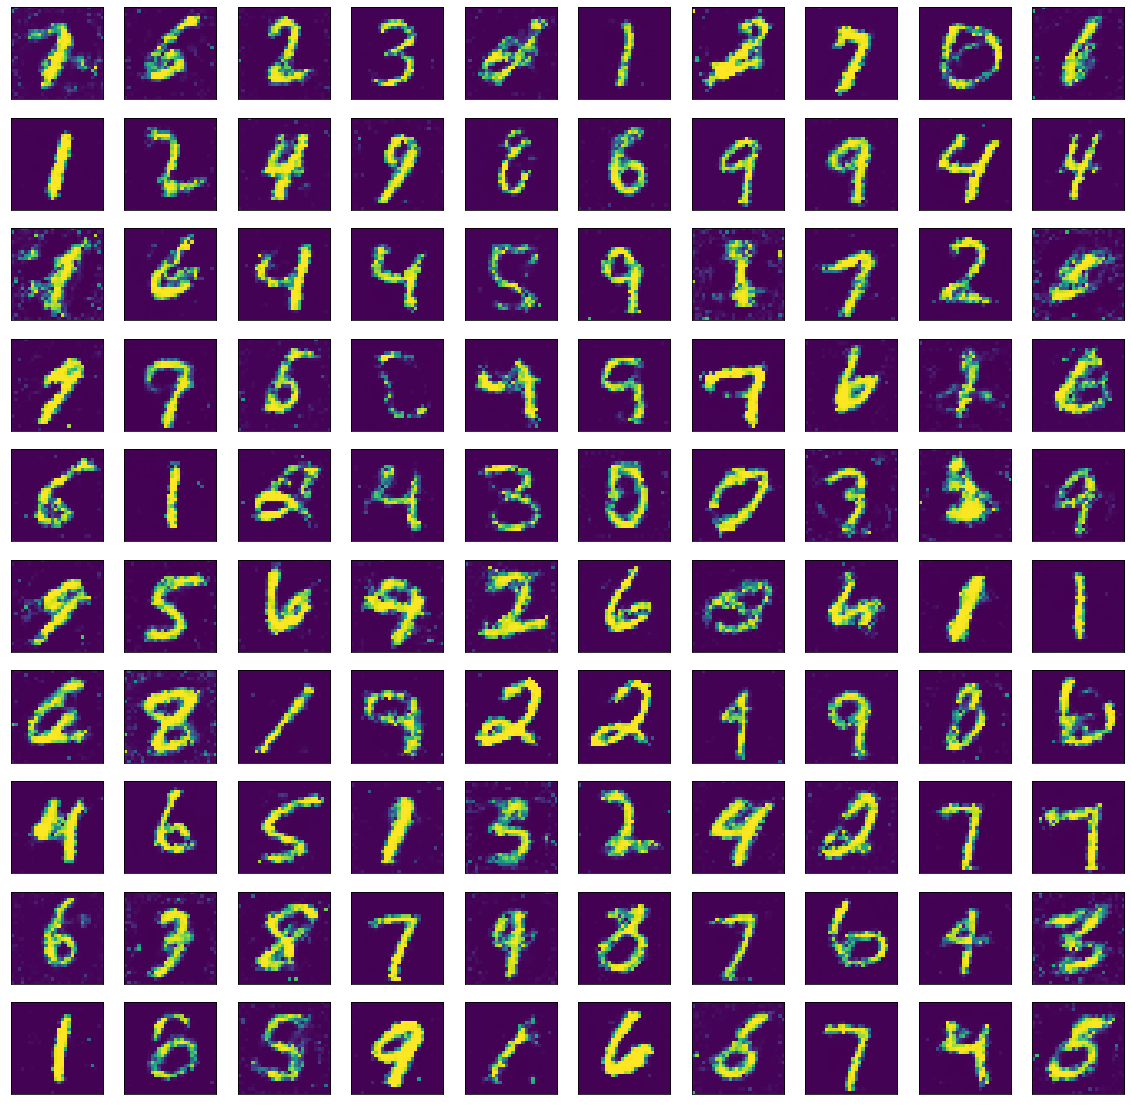

In [25]:
generate_image()